In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Setting random seed for consistent behavior
import random
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 8

#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
state_dim = 500
random_feature_dim = 5000
epochs = 6
n_obs = 8

trajectory_length = 6  # numer of node visits in a trajectory
num_desired_trajectories= 50

# choose env from "random", "small world" or "dead ends"
# TODO devouple batch_size from trajectory length for GraphEnv
# env = GraphEnv(n_nodes=n_nodes, n_items=n_obs, env='regular', action_type = "regular", batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

env = GraphEnv(env="grid", unique=True, args={"rows": 3, "cols": 3})

#dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs, env.items)
dataset = env.dataset.data

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

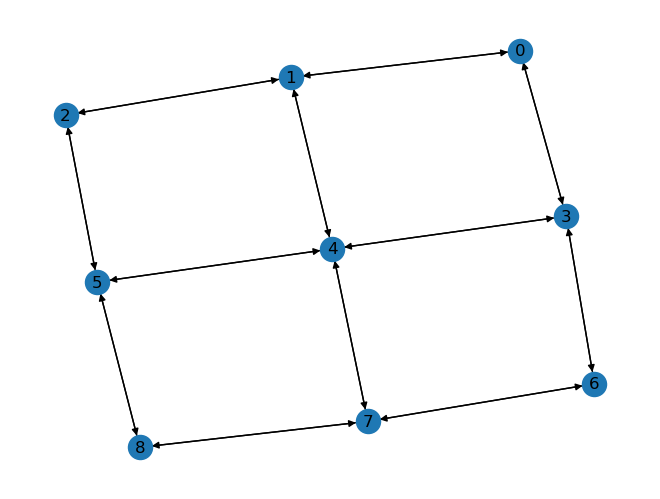

number of actions: 4
Sample trajectory:
tensor([[[5, 1, 8],
         [8, 2, 7],
         [7, 2, 6],
         [6, 3, 7],
         [7, 2, 6],
         [6, 3, 7],
         [7, 2, 6],
         [6, 3, 7],
         [7, 0, 4],
         [4, 3, 5],
         [5, 2, 4],
         [4, 0, 1],
         [1, 3, 2],
         [2, 1, 5]]])
S-O mapping:
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Adjacency Matrix:
tensor([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.]])
action-to-node:
{0: tensor([0, 1]), 1: tensor([1, 0]), 2: tensor([0, 3]), 3: tensor([3, 0]), 4: tensor([1, 2]), 5: tensor([2, 1]), 6: tensor([1, 4]), 7: tensor([4, 1]), 8: tensor([2, 5]), 9: tenso

In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float), create_using = nx.DiGraph)

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("Sample trajectory:")
for trajectory in dataloader:
    print(trajectory)
    break

print("S-O mapping:")
print(env.items)
print("Adjacency Matrix:")
print(adj)
print("action-to-node:")
print(env.action_to_node)
print("node-to-action-matrix:")
print(env.node_to_action_matrix)
print("affordance / node - to action:")
print(env.affordance)

In [4]:
# Our code
from trainer import POCMLTrainer
from model import POCML

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = POCML(n_obs = env.n_items,
                n_states = env.size,
                n_actions = env.n_actions,
                state_dim = state_dim,
                random_feature_dim = random_feature_dim,
                alpha = 1,
                beta = 4,
                memory_bypass=True,
                decay = 0.9)
    
trainer = POCMLTrainer(model=model, 
                       train_loader = dataloader,
                       lr_Q_o = 1, 
                       lr_V_o = 0.1, 
                       lr_Q_s = 0, 
                       lr_V_s = 0, 
                       lr_all = 0.32, 
                       mem_cleanup_rate = 0.0
                       )

loss_record = np.array(trainer.train(epochs)).reshape(epochs,-1)

Epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Current Trajectory tensor([[5, 1, 8],
        [8, 2, 7],
        [7, 2, 6],
        [6, 3, 7],
        [7, 2, 6],
        [6, 3, 7],
        [7, 2, 6],
        [6, 3, 7],
        [7, 0, 4],
        [4, 3, 5],
        [5, 2, 4],
        [4, 0, 1],
        [1, 3, 2],
        [2, 1, 5]])
initial state: tensor(5)
Print initial score tensor([0.3294, 0.3524, 0.3810, 0.3615, 0.3612, 0.9999, 0.3675, 0.3376, 0.3458])
Obs similarity
 tensor([[1.0000, 0.3748, 0.3684, 0.3615, 0.3449, 0.3294, 0.3652, 0.4022, 0.3442],
        [0.3748, 1.0000, 0.3784, 0.3409, 0.4000, 0.3524, 0.3606, 0.3588, 0.3470],
        [0.3684, 0.3784, 1.0000, 0.3566, 0.3673, 0.3810, 0.3708, 0.3454, 0.3612],
        [0.3615, 0.3409, 0.3566, 1.0000, 0.3734, 0.3615, 0.3687, 0.3917, 0.3829],
        [0.3449, 0.4000, 0.3673, 0.3734, 1.0000, 0.3612, 0.3920, 0.3572, 0.3610],
        [0.3294, 0.3524, 0.3810, 0.3615, 0.3612, 1.0000, 0.3675, 0.3376, 0.3458],
        [0.3652, 0.3606, 0.3708, 0.3687, 0.3920, 0.3675, 1.0000, 0.3813, 0.3539]

In [5]:
print(model.Q.T @ model.Q)
print((model.Q.T @ model.Q).shape)

tensor([[4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209],
        [4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209, 4.4209]],
       grad_fn=<MmBackward0>)
torch.Size([9, 9])


In [6]:
print(model.V.T @ model.V)

tensor([[6.8193e-15, 1.6037e-15, 1.3120e-15, 2.5407e-15],
        [1.6037e-15, 6.6244e-15, 1.4866e-15, 1.7781e-15],
        [1.3120e-15, 1.4866e-15, 6.7137e-15, 1.2929e-15],
        [2.5407e-15, 1.7781e-15, 1.2929e-15, 6.7104e-15]],
       grad_fn=<MmBackward0>)


In [10]:
print(model.M.T @ model.M.conj())

tensor([[1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000-1.3097e-10j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+5.8208e-11j,
         0.9999-1.5309e-09j],
        [1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000-1.3097e-10j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
         1.0000+0.0000e+00j, 1.0000+0.0000e+00j, 1.0000+0.0000e+00j,
    

Text(0.5, 0, 'Epochs')

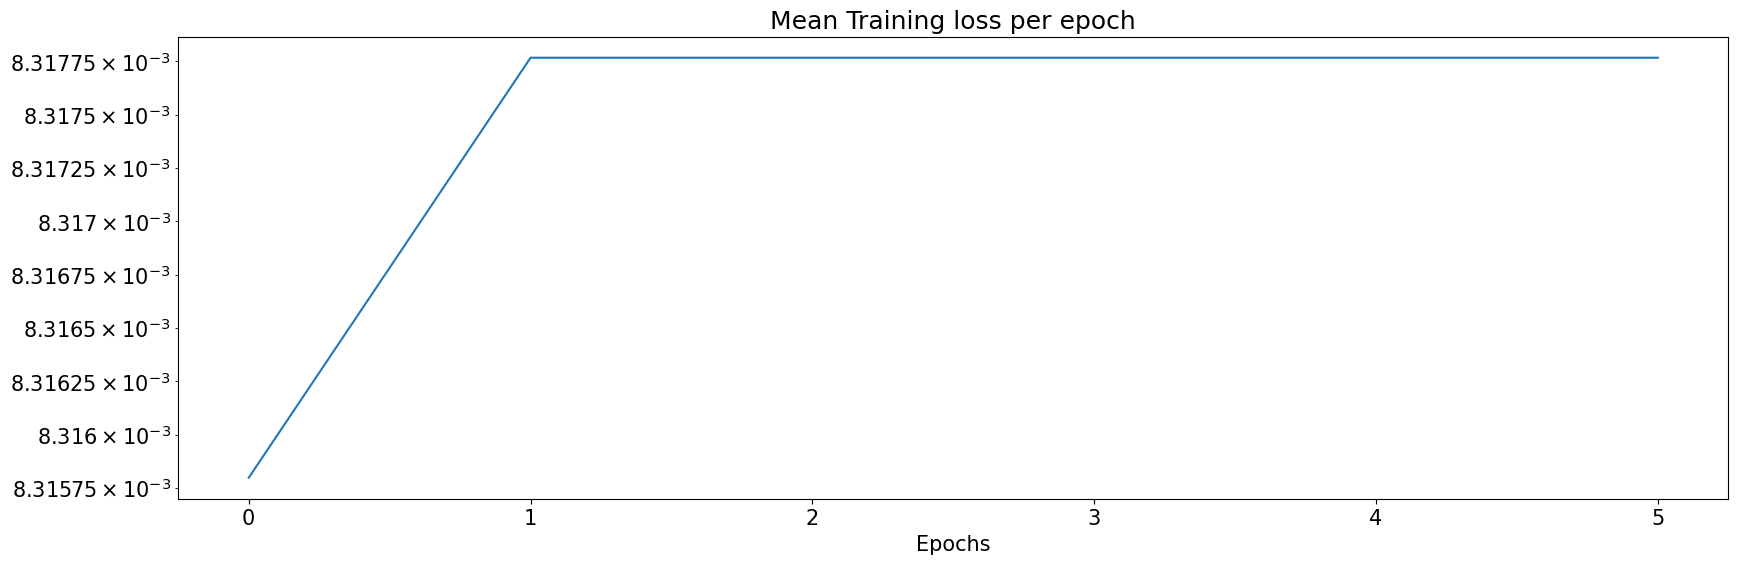

In [8]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1)/(env.num_desired_trajectories * (env.batch_size-1) ))
plt.yscale('log')
plt.title('Mean Training loss per epoch') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

[  0.1   1.   10.  100. ]


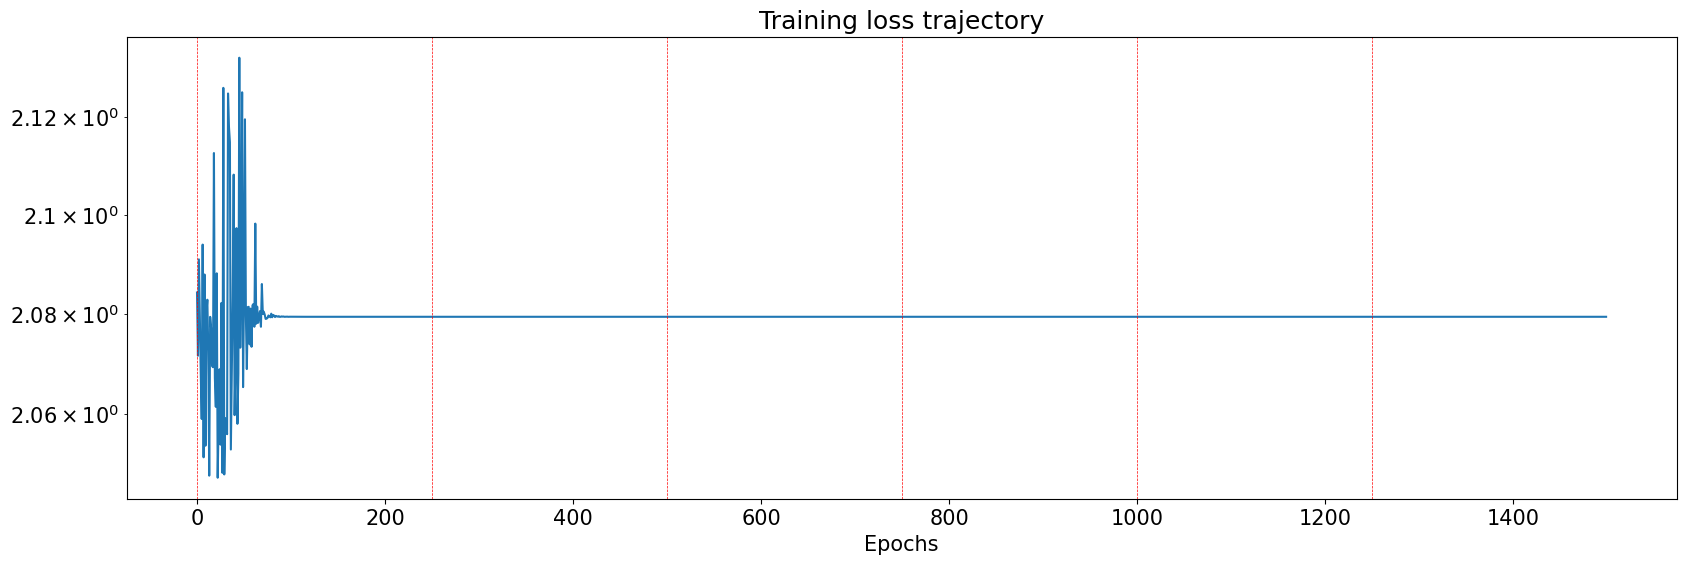

In [9]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(loss_record.reshape(-1))
plt.yscale('log')
plt.title('Training loss trajectory') # mean over the # trajectory and # steps in trajectory 
plt.xlabel('Epochs')

# Get the current y-ticks
yticks = plt.yticks()[0]

print(yticks)

# Add vertical lines at each multiple of 5

for i in range(0, len(loss_record.reshape(-1)), num_desired_trajectories * (trajectory_length-1)):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.5)



In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:

device = torch.device("cpu")

# CML 
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            #steps, o_record = model.plan(start_idx, goal_idx, env, False)
            steps = model.plan(state, affordance=None):

        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 